# Extracting

Let us begin by extracting our data into Pandas dataframes. I have created a simple python module just for that task. 

All dataframes will have duplicate rows deleted and empty strings will be substituted with NaN values. This is a very basic transformation that can be done for almost any data. Further transformations will depend on what we see in our dataframes.

In [1]:
import extract, config
import pandas as pd

datasources_config_path = './config/data_source_config.json'
extractor = extract.Extractor(datasources_config_path)

product_invoices_df = extractor.load_json_files_to_df('product_invoices')
product_package_types_df = extractor.load_json_files_to_df('product_package_types')
product_shipments_df = extractor.load_json_files_to_df('product_shipments')
provider_invoices_df = extractor.load_json_files_to_df('provider_invoices')
provider_prices_df = extractor.load_json_files_to_df('provider_prices')


# Checking and Transforming

Now let us check our dataframes one by one and fix anything funky that might be going on with them.

I will focus on missing data and potential primary keys that are not unique.

In [2]:
import transform
transformer = transform.Transformer()

In [3]:
# the list of transactions where we have collected the shipment fee from the buyers
product_invoices_df

,transaction_id,amount,user_invoice_date
0,221271390,3.150000,2018-12-20
1,153588634,3.150000,2018-08-24
2,270671460,2.400000,2019-03-01
3,158409145,2.730000,2018-09-04
4,178911135,2.730000,2018-10-18
...,...,...,...
55409,131206431,2.400000,2018-06-13
55410,252787333,2.400000,2019-02-08
55411,250082599,2.400000,2019-01-30
55412,244563332,2.730000,2019-01-31


In [4]:
# Basic checks
transformer.check_if_unique_id(product_invoices_df, 'transaction_id')
transformer.check_missing_values(product_invoices_df)

The red background returned here looks scary but that is just my logs doing what they are supposed to - we can see that the transaction_id is unique and there are no missing values. Moving on to the next dataframe!

In [5]:
#the list of package types we have on our platform that a seller can select.
product_package_types_df

,id,description
0,7,Ã‰paiss. max 3cm 0.25kg
1,8,0.75kg
2,9,2kg
3,10,0.5kg
4,11,1kg
...,...,...
129,275,"Max. 20 kg, 120 x 60 x 60 cm"
130,276,"Max. 20 kg, 120 x 60 x 60 cm"
131,277,"Max. 20 kg, 120 x 60 x 60 cm"
132,292,"Max. 10 kg, 100 Ã— 50 Ã— 50 cm"


The description data in the product_package_types_df looks quite ugly. It includes both dimensions and weight of the packages. Dimensions are not referred to in any of the other tables. We will transform this data so that a wight value is saved in a separate column. This way we can make the most of the product_package data - for example, we can later compare whether the shipping information matches the information provided by the sellers.

In [6]:
product_package_types_df['weight_reported'] = product_package_types_df['description'].apply(transformer.cleanup_description)
product_package_types_df

,id,description,weight_reported
0,7,Ã‰paiss. max 3cm 0.25kg,0.25
1,8,0.75kg,0.75
2,9,2kg,2
3,10,0.5kg,0.5
4,11,1kg,1
...,...,...,...
129,275,"Max. 20 kg, 120 x 60 x 60 cm",20
130,276,"Max. 20 kg, 120 x 60 x 60 cm",20
131,277,"Max. 20 kg, 120 x 60 x 60 cm",20
132,292,"Max. 10 kg, 100 Ã— 50 Ã— 50 cm",10


Now that looks much more usable!

In [7]:
transformer.check_if_unique_id(product_package_types_df, 'id')
transformer.check_missing_values(product_package_types_df)

After doing the cheks, we can see there were missing description values, but the new weight_reported transformed them - you can't see it here, but it set them to the number 0.

In [8]:
#the list of shipments that we see in our data
product_shipments_df

,tracking_code,from_country,to_country,package_type_id,transaction_id,shipping_label_created,buyer_id,seller_id
0,30611711,FR,FR,11,182260673,2018-10-13 10:38:35,16471055,18098417
1,33192017,FR,FR,10,203716496,2018-11-14 18:43:26,511189,16281325
2,33286778,FR,FR,11,203394963,2018-11-15 21:39:24,13351339,15644819
3,28134416,FR,FR,11,161640430,2018-09-06 09:44:07,18319157,855863
4,29892135,FR,FR,10,174990551,2018-10-04 08:37:26,16998722,1691012
...,...,...,...,...,...,...,...,...
56291,33409354,FR,FR,12,200390728,2018-11-17 18:21:51,19699917,16662926
56292,40949324,FR,FR,10,265068264,2019-02-17 19:14:26,11879770,15749068
56293,33929048,FR,FR,10,210053751,2018-11-24 08:56:13,11880641,15285615
56294,28406245,FR,FR,10,164804384,2018-09-10 18:46:39,17863854,11502596


In [9]:
# Basic checks
transformer.check_if_unique_id(product_shipments_df, 'transaction_id')
transformer.check_if_unique_id(product_shipments_df, 'tracking_code')
transformer.check_missing_values(product_shipments_df)

In [10]:
# Finding out the values with duplicated tracking_code
ids = product_shipments_df["tracking_code"]
product_shipments_df_duplicated_tracking = product_shipments_df[ids.isin(ids[ids.duplicated()])]
product_shipments_df_duplicated_tracking

,tracking_code,from_country,to_country,package_type_id,transaction_id,shipping_label_created,buyer_id,seller_id
15069,12878564,FR,FR,11,8638716,2015-05-19 18:50:57,1702596,105141
52011,12878564,ES,FR,135,271780177,2019-02-26 12:14:31,11869825,21649195
3124,12795958,FR,FR,11,7789938,2015-04-25 20:07:56,1827490,1164460
7354,12795958,ES,FR,135,260812237,2019-02-11 16:54:05,21341323,22008389


We can see that there are 4 duplicated tracking code values. This seems like a data quality issue, which needs explanation - these codes are clearaly associated with different shipments. In order to join this dataframe with other dataframes, we can either drop the above data or keep the most recent record. I am choosing to drop it in the interest of faster analysis but in a real life scenario, I would flag such an issue and keep hold of that data.

In [11]:
# Dropping duplicated values and checking whether tracking_code is unique now - this can be extracted in a separate function
duplicates = product_shipments_df_duplicated_tracking.tracking_code.unique()
product_shipments_df = product_shipments_df[~product_shipments_df.tracking_code.isin(duplicates)]
transformer.check_if_unique_id(product_shipments_df, 'tracking_code')

True

On to the next dataframe - I bet we will have to do the same drop.

In [12]:
# the shipping labels that the shipping provider is charging us for.
provider_invoices_df

,tracking_code,from_country,to_country,weight_measured,amount
0,36075318,FR,FR,0.0,2.40
1,37899329,FR,FR,870.0,2.73
2,36344250,FR,FR,280.0,2.40
3,38425854,FR,FR,160.0,2.40
4,15587085,FR,FR,630.0,3.28
...,...,...,...,...,...
56289,39937773,FR,FR,540.0,2.73
56290,39588954,FR,FR,1200.0,3.15
56291,35152712,FR,FR,540.0,2.40
56292,21507505,FR,FR,0.0,2.40


In [13]:
# Basic checks
transformer.check_if_unique_id(provider_invoices_df, 'tracking_code')
transformer.check_missing_values(provider_invoices_df)

In [14]:
# Finding out the values with duplicated tracking_code
ids = provider_invoices_df["tracking_code"]
provider_invoices_df_duplicated_tracking = provider_invoices_df[ids.isin(ids[ids.duplicated()])]
provider_invoices_df_duplicated_tracking

,tracking_code,from_country,to_country,weight_measured,amount
44893,12795958,FR,FR,NaN,3.28
5704,12795958,ES,FR,0.0,3.73
29611,12878564,FR,FR,NaN,3.28
9082,12878564,ES,FR,0.0,3.73


The same repeated tracking_ids can be found in the provider_invoices data and we will get rid of them for the sake of easier exploration of trends. 

In [15]:
# Dropping duplicated values and checking whether tracking_code is unique now - this can be extracted in a separate function
# provider_invoices_df = provider_invoices_df.drop(provider_invoices_df[ids.isin(duplicates)].index)
provider_invoices_df = provider_invoices_df[~provider_invoices_df.tracking_code.isin(duplicates)]

transformer.check_if_unique_id(provider_invoices_df, 'tracking_code')

True

Another transformation we can do here is to convert the measured weight from gr to kg. I see other tables have weight saved in kg, so such transformation will make future comparisons easier.

In [16]:
#Transforming provider_invoices_df weight to be in kg
# provider_invoices_df["weight_measured"] = provider_invoices_df["weight_measured"]/1000
transformed_provider_invoices_df = provider_invoices_df.copy();
transformed_provider_invoices_df["weight_measured"] = provider_invoices_df["weight_measured"]/1000
transformed_provider_invoices_df


,tracking_code,from_country,to_country,weight_measured,amount
0,36075318,FR,FR,0.00,2.40
1,37899329,FR,FR,0.87,2.73
2,36344250,FR,FR,0.28,2.40
3,38425854,FR,FR,0.16,2.40
4,15587085,FR,FR,0.63,3.28
...,...,...,...,...,...
56289,39937773,FR,FR,0.54,2.73
56290,39588954,FR,FR,1.20,3.15
56291,35152712,FR,FR,0.54,2.40
56292,21507505,FR,FR,0.00,2.40


I wonder whether the repeated tracking code will be found in the product_invoices data - we can find that based on the unique transaction IDs we saw for the tracking codes in the  product_shipments data.

In [17]:
product_invoices_df

duplicates = [8638716, 271780177, 7789938, 260812237]

product_invoices_df.loc[product_invoices_df['transaction_id'].isin(duplicates)]
# product_invoices_df = product_invoices_df.set_index(['transaction_id'])
# print(product_invoices_df.loc[7789938])

,transaction_id,amount,user_invoice_date
44796,8638716,2.730000,2015-05-26
12882,271780177,3.727273,2019-03-06
40042,7789938,2.730000,2015-05-05
14834,260812237,3.727273,2019-02-19


The repeated tracking code is in the product_invoices data. We can drop it but when we join this table with the others, it won't matter as the values will be dropped anyway.

In [18]:
#the prices that we are being charged by the provider based on weight, route of the shipment.
provider_prices_df

,from_country,to_country,price,actual_package_size
0,FR,FR,2.40,0.5 kg
1,FR,FR,2.73,1 kg
2,FR,FR,3.15,2 kg
3,FR,FR,3.54,3 kg
4,FR,FR,4.27,5 kg
...,...,...,...,...
139,ES,LU,6.77,5 kg
140,ES,LU,8.96,7 kg
141,ES,LU,11.75,10 kg
142,ES,LU,15.58,15 kg


This seems like reference data from the provider, which we can use to double-check whether the provider charges us fairly. We could remove the kg in actual_package_size, which would make comparisons easier. I will leave this task for later.

To make things easier - let's join product_shipments_df, product_invoices_df, and provider_invoices_df! This will allow us to have one main dataset, which will make explorations and comparisons easier. We know we can treat transaction_id as a unique key in product_invoices_df and product_shipments_df. Now we also know that tracking_code is unique and since it exists in both product_shipments_df and provider_invoices_df, we can easily perform the join.

I will first rename the columns that exist in more than one table so we don't get confused when the join happnes.

In [19]:
renamed_product_shipments_df = product_shipments_df.rename(columns={'from_country':'from_country_product', 'to_country':'to_country_product'})
renamed_product_invoices_df = product_invoices_df.rename(columns={'amount':'amount_product'})
renamed_provider_invoices_df = transformed_provider_invoices_df.rename(columns={'from_country':'from_country_provider', 'to_country':'to_country_provider', 
                                     'amount':'amount_provider'})

product_invoices_shipments_df = pd.merge(renamed_product_shipments_df, renamed_product_invoices_df, on='transaction_id')
product_provider_invoices_shipments_df = pd.merge(product_invoices_shipments_df, renamed_provider_invoices_df, 
                                                  on='tracking_code')

full_df = pd.merge(product_package_types_df[['weight_reported', 'id']],product_provider_invoices_shipments_df,
                                                  left_on='id', right_on='package_type_id', how='right')

full_df

,weight_reported,id,tracking_code,from_country_product,to_country_product,package_type_id,transaction_id,shipping_label_created,buyer_id,seller_id,amount_product,user_invoice_date,from_country_provider,to_country_provider,weight_measured,amount_provider
0,1,11,30611711,FR,FR,11,182260673,2018-10-13 10:38:35,16471055,18098417,2.730000,2018-10-22,FR,FR,0.96,2.73
1,1,11,33286778,FR,FR,11,203394963,2018-11-15 21:39:24,13351339,15644819,2.730000,2018-12-02,FR,FR,0.00,2.73
2,1,11,28134416,FR,FR,11,161640430,2018-09-06 09:44:07,18319157,855863,2.730000,2018-09-17,FR,FR,0.97,2.73
3,1,11,24625209,FR,FR,11,133046864,2018-06-10 09:24:23,15127170,14132726,2.730000,2018-06-20,FR,FR,0.42,2.40
4,1,11,30455242,FR,FR,11,178818806,2018-10-11 05:50:30,11952923,13446633,2.730000,2018-10-16,FR,FR,0.00,2.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554029,20,145,37452359,FR,FR,145,229372718,2019-01-09 13:26:12,12733487,20170335,10.090000,2019-01-19,FR,FR,0.00,10.01
554030,20,145,43647656,FR,FR,145,286022137,2019-03-14 17:09:02,21864545,19976223,10.091667,2019-03-20,FR,FR,0.00,10.01
554031,20,145,40214975,FR,FR,145,258378876,2019-02-09 11:26:15,14641196,15336055,10.091667,2019-02-13,FR,FR,0.00,10.01
554032,20,145,39101560,FR,FR,145,250689914,2019-01-28 18:56:00,21567548,14968079,10.091667,2019-02-06,FR,FR,0.00,10.01


I am noticing that we have dropped some records when joining product_shipments_df, product_invoices_df, and provider_invoices_df. It would be useful to check whether there are provider invoices that do not correspond to any product invoices but for the sake of the current task, I am assuming any such discrepancies might be because of incomplete data and I will focus on more exciting explorations.

The next thing we can do is to check whether the duplicated columns in the tables we just joined match and if not - we can drop them.

In [20]:
#this can be more elegant - I know it won't scale well
isFromCountrySame = full_df['from_country_product'].equals(full_df['from_country_provider'])
if isFromCountrySame:
     full_df.drop('from_country_provider', axis=1, inplace=True)
    
isToCountrySame = full_df['to_country_product'].equals(full_df['to_country_provider'])
if isToCountrySame:
     full_df.drop('to_country_provider', axis=1, inplace=True)

full_df

,weight_reported,id,tracking_code,from_country_product,to_country_product,package_type_id,transaction_id,shipping_label_created,buyer_id,seller_id,amount_product,user_invoice_date,weight_measured,amount_provider
0,1,11,30611711,FR,FR,11,182260673,2018-10-13 10:38:35,16471055,18098417,2.730000,2018-10-22,0.96,2.73
1,1,11,33286778,FR,FR,11,203394963,2018-11-15 21:39:24,13351339,15644819,2.730000,2018-12-02,0.00,2.73
2,1,11,28134416,FR,FR,11,161640430,2018-09-06 09:44:07,18319157,855863,2.730000,2018-09-17,0.97,2.73
3,1,11,24625209,FR,FR,11,133046864,2018-06-10 09:24:23,15127170,14132726,2.730000,2018-06-20,0.42,2.40
4,1,11,30455242,FR,FR,11,178818806,2018-10-11 05:50:30,11952923,13446633,2.730000,2018-10-16,0.00,2.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554029,20,145,37452359,FR,FR,145,229372718,2019-01-09 13:26:12,12733487,20170335,10.090000,2019-01-19,0.00,10.01
554030,20,145,43647656,FR,FR,145,286022137,2019-03-14 17:09:02,21864545,19976223,10.091667,2019-03-20,0.00,10.01
554031,20,145,40214975,FR,FR,145,258378876,2019-02-09 11:26:15,14641196,15336055,10.091667,2019-02-13,0.00,10.01
554032,20,145,39101560,FR,FR,145,250689914,2019-01-28 18:56:00,21567548,14968079,10.091667,2019-02-06,0.00,10.01


In [21]:
# comparing amount columns
isAmtSame = full_df['amount_product'].equals(full_df['amount_provider'])
print(isAmtSame)

False


Now this is interesting - we can see that the amount in the product invoices differs than the amount in the provider invoices. We need to explore further.

# Exploring

Starting with a basic description of the numeric values in our new main table.

In [22]:
full_df.describe()

,id,tracking_code,package_type_id,transaction_id,buyer_id,seller_id,amount_product,weight_measured,amount_provider
count,554034.000000,5.540340e+05,554034.000000,5.540340e+05,5.540340e+05,5.540340e+05,554034.000000,550882.000000,554034.000000
mean,11.118265,3.007744e+07,11.118265,1.750835e+08,1.326970e+07,1.323260e+07,2.654765,0.455150,2.644441
std,7.145703,8.814735e+06,7.145703,7.359585e+07,5.270595e+06,5.502841e+06,0.289453,0.542077,0.340500
min,10.000000,1.251388e+07,10.000000,8.542080e+05,1.830000e+02,9.800000e+01,2.380000,0.000000,2.400000
25%,10.000000,2.255758e+07,10.000000,1.151012e+08,1.215802e+07,1.215071e+07,2.400000,0.000000,2.400000
50%,11.000000,3.017752e+07,11.000000,1.782352e+08,1.400598e+07,1.407965e+07,2.730000,0.320000,2.400000
75%,11.000000,3.770647e+07,11.000000,2.383260e+08,1.652081e+07,1.669654e+07,2.730000,0.670000,2.730000
max,153.000000,4.535205e+07,153.000000,3.000001e+08,2.355383e+07,2.354916e+07,11.866667,26.880000,15.580000


We can see that the amount in the product invoices is slightly higher on average than the amount in the provider invoices. The lower standart deviation of the amount in the product invoices suggest that data is a bit less varied and tends to be closer to the mean compared to the amount in the provider invoices. But when is the discrepancy observed - does it depend on country, buyer, seller, timing, weight? Bring on the graphs - we are about to find out. 

Text(0.5, 1.0, 'Distribution of amount in provider invoices')

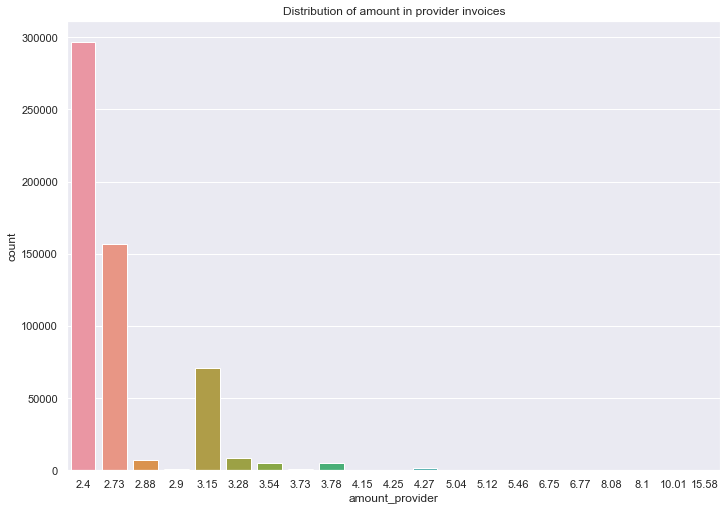

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
full_df.round({'amount_product': 2, 'amount_provider': 2})
plotAmtProvider = sns.countplot(x='amount_provider',data=full_df.round(2))
plt.title('Distribution of amount in provider invoices')

Text(0.5, 1.0, 'Distribution of amount in product invoices')

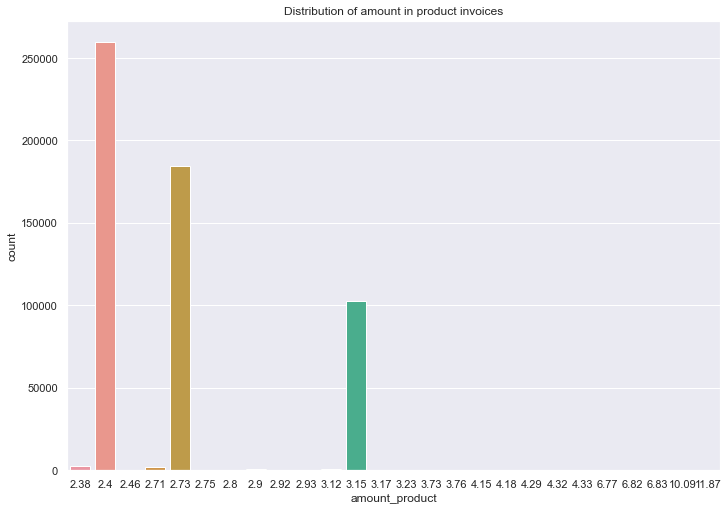

In [45]:
plotAmtProduct = sns.countplot(x="amount_product",data=full_df.round(2))
plt.title('Distribution of amount in product invoices')

In [25]:
# sns.regplot(x=full_df["weight_measured"], y=full_df["amount_provider"])

In [26]:
# sns.regplot(x=full_df["weight_measured"], y=full_df["amount_product"])

In [27]:
# sns.regplot(x=full_df["weight_reported"], y=full_df["amount_product"])

Q2Growth rate: Do number of orders increase with time? Do number of sellers increase with time? how many shippings does a seller do? how many  orders does a single buyer receive? are packages becoming heavier? trends according to countries

Churn - the rate of losing customers (retention rate)

Q3 if numbers of shippings are increasing, Vinted could negotiate lower prices with the shipping companies as it is becoming a bigger customer

In [38]:
# Changing the type of some columns to aid further exploration
full_df[["shipping_label_created", "user_invoice_date"]] = full_df[["shipping_label_created", "user_invoice_date"]].apply(pd.to_datetime)
full_df["shipping_label_created_year_month"] = full_df["shipping_label_created"].dt.strftime('%Y-%m')
full_df['weight_reported'] = full_df['weight_reported'].astype(float)

# Creating a dataframe with mean values per month
mean_full_df = full_df.groupby('shipping_label_created_year_month').mean()

,weight_reported,id,tracking_code,package_type_id,transaction_id,buyer_id,seller_id,amount_product,weight_measured,amount_provider
shipping_label_created_year_month,,,,,,,,,,
2015-02,1.500000,11.500000,1.259966e+07,11.500000,5.744767e+06,1.212317e+06,1.139398e+06,2.946667,NaN,3.530000
2015-03,1.581633,11.530612,1.266420e+07,11.530612,6.321499e+06,1.138296e+06,1.039485e+06,2.962041,NaN,3.555510
2015-04,1.315217,11.228261,1.276835e+07,11.228261,7.370446e+06,1.287486e+06,1.185773e+06,2.841522,NaN,3.411522
2015-05,1.396774,11.335484,1.286140e+07,11.335484,8.373841e+06,1.366561e+06,1.164122e+06,2.881935,NaN,3.460000
2015-06,1.318548,11.266129,1.296354e+07,11.266129,9.341204e+06,1.565568e+06,1.165229e+06,2.851210,NaN,3.423548
2015-07,1.193182,11.102273,1.304890e+07,11.102273,1.033097e+07,1.754481e+06,1.638437e+06,2.789318,NaN,3.349318
2015-08,1.305755,11.237410,1.312506e+07,11.237410,1.121913e+07,2.018748e+06,1.702260e+06,2.842014,NaN,3.412374
2015-09,1.357651,11.295374,1.320272e+07,11.295374,1.222192e+07,2.714831e+06,1.950786e+06,2.865267,NaN,3.440142
2015-10,1.401575,11.349081,1.329669e+07,11.349081,1.376203e+07,3.199145e+06,2.466192e+06,2.886063,NaN,3.465039


<module 'matplotlib.pyplot' from 'C:\\Users\\ellzv\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

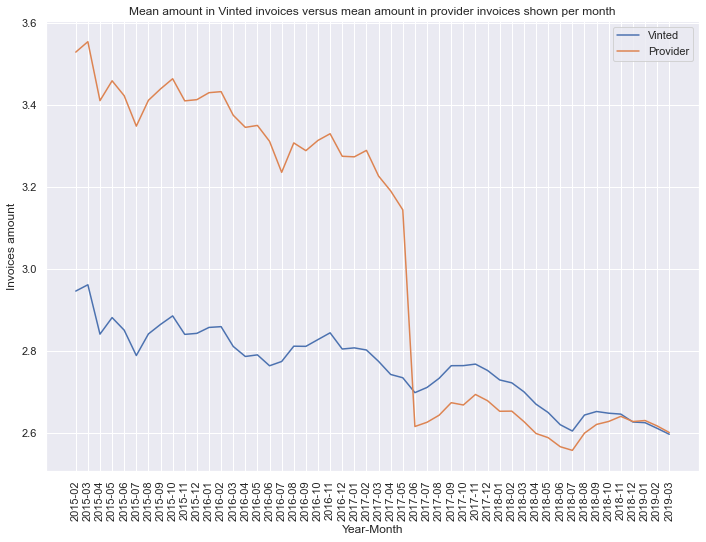

In [35]:
# Line plot - amount
sns.lineplot(x="shipping_label_created_year_month", y="amount_product", data=mean_full_df)
sns.lineplot(x="shipping_label_created_year_month", y="amount_provider", data=mean_full_df)
plt.xlabel('Year-Month')
plt.ylabel('Invoices amount')
plt.xticks(rotation=90)
plt.legend(['Vinted', 'Provider'])
plt.title('Mean amount in Vinted invoices versus mean amount in provider invoices shown per month')
plt

We can see that the discrepancy has reduced with time.

<module 'matplotlib.pyplot' from 'C:\\Users\\ellzv\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

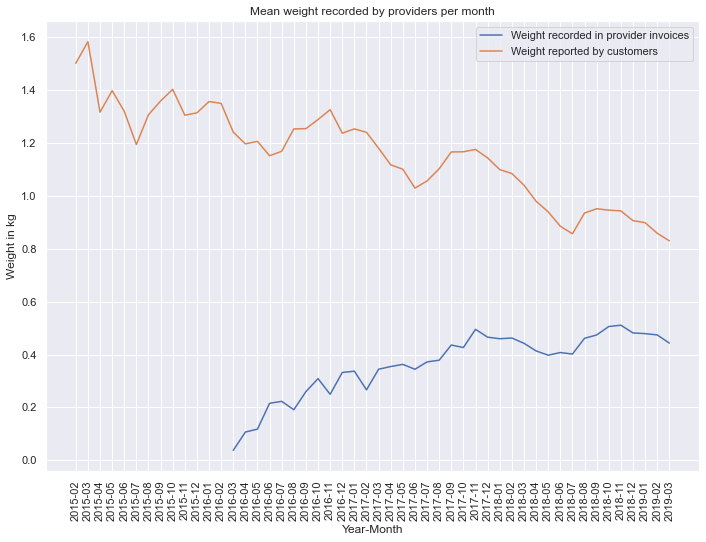

In [44]:
# Line plot - weight
sns.lineplot(x="shipping_label_created_year_month", y="weight_measured", data=mean_full_df)
sns.lineplot(x="shipping_label_created_year_month", y="weight_reported", data=mean_full_df)
plt.xlabel('Year-Month')
plt.ylabel('Weight in kg')
plt.xticks(rotation=90)
plt.legend(['Weight recorded in provider invoices', 'Weight reported by customers'])
plt.title('Mean weight recorded by providers per month')
plt

On average, it seems like the weight selected by users is higher than theactual reported weight.

In [31]:
unique_full_df = full_df.groupby('shipping_label_created_year_month').nunique()
unique_full_df

,weight_reported,id,tracking_code,from_country_product,to_country_product,package_type_id,transaction_id,shipping_label_created,buyer_id,seller_id,amount_product,user_invoice_date,weight_measured,amount_provider
shipping_label_created_year_month,,,,,,,,,,,,,,
2015-02,2,2,6,1,1,2,6,6,6,6,4,4,0,2
2015-03,3,3,49,1,1,3,49,49,49,49,3,27,0,3
2015-04,3,3,92,1,1,3,92,92,92,89,3,33,0,3
2015-05,3,3,155,1,1,3,155,155,154,152,3,35,0,3
2015-06,3,3,124,1,1,3,124,124,123,122,3,38,0,3
2015-07,3,3,88,1,1,3,88,88,86,88,3,32,0,3
2015-08,3,3,139,1,1,3,139,139,137,137,3,41,0,3
2015-09,3,3,281,1,1,3,281,281,276,275,3,39,0,3
2015-10,3,3,381,1,1,3,381,381,375,370,3,44,0,3


I am noticing that the unique number of buyers and sellers is quite similar across all months. It is also obviously increasing. This can be explored further but for now, let's check what the number of transaction looks when plotted over time.

<module 'matplotlib.pyplot' from 'C:\\Users\\ellzv\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

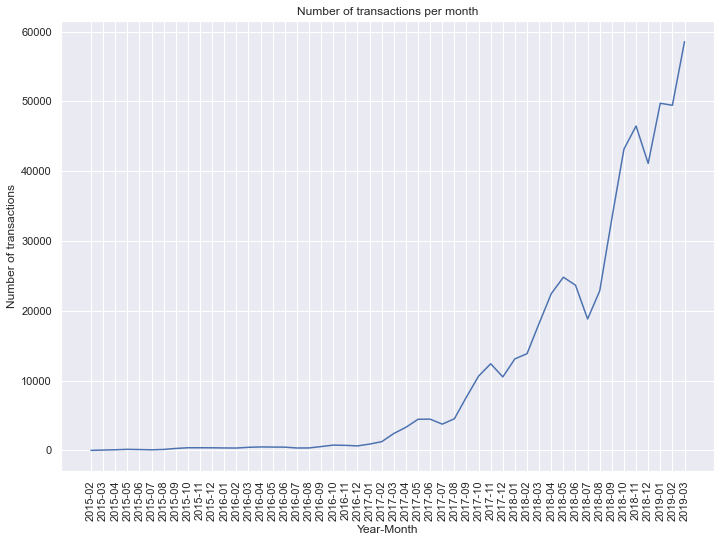

In [32]:
# Line plot - transactions
sns.lineplot(x="shipping_label_created_year_month", y="transaction_id", data=unique_full_df)
plt.xlabel('Year-Month')
plt.ylabel('Number of transactions')
plt.xticks(rotation=90)
plt.title('Number of transactions per month')
plt

The number of transactions has been increasing steadily since 2017. The beginning of this growth seem to correlate with a drop in the mean shipping price charged by provider. I am assuming a better deal was negotiated in June 2017 due to the increase in shippings.

<module 'matplotlib.pyplot' from 'C:\\Users\\ellzv\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

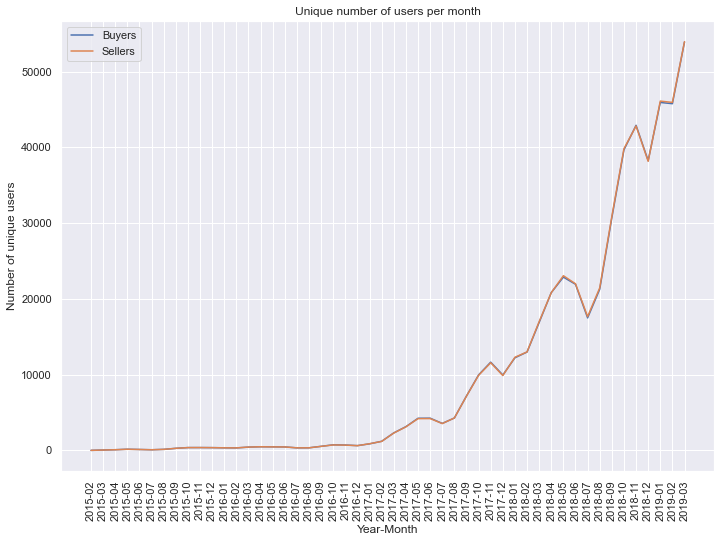

In [33]:
# Lien plot - buyers vs buyers
# sns.lineplot(x="shipping_label_created_year_month", y="buyer_id", data=unique_full_df)
# sns.lineplot(x="shipping_label_created_year_month", y="seller_id", data=unique_full_df)
# sns.set_style(style="darkgrid")
# plt.xlabel('Year-Month')
# plt.ylabel('Number of unique users')
# plt.xticks(rotation=90)
# plt.legend(['Buyers', 'Sellers'])
# plt.title('Unique number of users per month')
# plt

# Conclusion

Findings:


Limitations to my exploration:
A lot of my graphs depended on means, which gives a glimpse at the data but if I had more time, I would preforme a more in-depth analysis. I also didn't have the time to use the provider_prices data, which could have helped explore whether providers are overcharching us.

Design improvements:
I was eager to perform analysis as quickly as possible and some of the practices you see are not production ready.
I would imagine the application to have batch processing, which would allow for monitoring of some key indicators daily or weekly. Reference data can be stored  separately so we don’t load and clean it all the time. We need to keep track of the files that have already been loaded.
